# Project: Identify Customer Segments

In this project, we will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by Bertelsmann Arvato Analytics, and represents a real-life data science task.

NOTE: The dataset's used in this notebook are Bertlesman's propery and the notebook was only executed through Udacity's classroom to access them.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display



# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. We will use this information to cluster the general population into groups with similar demographic properties. Then, we will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, let's load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
print(feat_info.shape)
azdias.head()
# print(feat_info.head())

(891221, 85)
(85, 4)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [5]:
display(Markdown("Data_Dictionary.md")) # display the md file with feature info

# Data Dictionary for Identify Customer Segments Data

## Introduction

The data for this project consist of two files:

- Udacity_AZDIAS_Subset.csv: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)
- Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)

The columns in the general demographics file and customers data file are the
same. This file documents the features that appear in the data files, sorted in
order of appearance. Sections of this file is based on the level of measurement
of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of
feature attributes, including information level, data type, and codes for
missing or unknown values.

### Table of Contents

 1. Person-level features
 2. Household-level features
 3. Building-level features
 4. RR4 micro-cell features
 5. RR3 micro-cell features
 6. Postcode-level features
 7. RR1 neighborhood features
 8. PLZ8 macro-cell features
 9. Community-level features

-----

## 1. Person-level features

### 1.1. AGER_TYP
Best-ager typology
- -1: unknown
-  0: no classification possible
-  1: passive elderly
-  2: cultural elderly
-  3: experience-driven elderly

### 1.2. ALTERSKATEGORIE_GROB
Estimated age based on given name analysis
- -1: unknown (missing)
-  0: unknown (cannot be determined)
-  1: < 30 years old
-  2: 30 - 45 years old
-  3: 46 - 60 years old
-  4: > 60 years old
-  9: uniformly distributed

### 1.3. ANREDE_KZ
Gender
- -1: unknown (missing)
-  0: unknown (cannot be determined)
-  1: male
-  2: female

### 1.4. CJT_GESAMTTYP
Customer-Journey-Typology: preferred information and buying channels for
consumer
- 0: unknown
- 1: Advertising- and Consumptionminimalist
- 2: Advertising- and Consumptiontraditionalist
- 3: advertisinginterested Store-shopper
- 4: advertisinginterested Online-shopper
- 5: Advertising- and Cross-Channel-Enthusiast
- 6: Advertising-Enthusiast with restricted Cross-Channel-Behaviour

### 1.5. FINANZ_MINIMALIST, FINANZ_SPARER, FINANZ_VORSORGER, FINANZ_ANLEGER,
###      FINANZ_UNAUFFAELLIGER, FINANZ_HAUSBAUER
Financial typology, for each dimension:
- -1: unknown
-  1: very high
-  2: high
-  3: average
-  4: low
-  5: very low

Dimension translations:
- MINIMALIST: low financial interest
- SPARER: money-saver
- VORSORGER: be prepared
- ANLEGER: investor
- UNAUFFAELLIGER: inconspicuous
- HAUSBAUER: home ownership

### 1.6. FINANZTYP
Most descriptive financial type for individual
- -1: unknown
-  1: low financial interest (MINIMALIST)
-  2: money-saver (SPARER)
-  3: home ownership (HAUSBAUER)
-  4: be prepared (VORSORGER)
-  5: investor (ANLEGER)
-  6: inconspicuous (UNAUFFAELLIGER)

### 1.7. GEBURTSJAHR
Year of birth
- missing data encoded as 0

### 1.8. GFK_URLAUBERTYP
Vacation habits
-  1: Event travelers
-  2: Family-oriented vacationists
-  3: Winter sportspeople
-  4: Culture lovers
-  5: Nature fans
-  6: Hiker
-  7: Golden ager
-  8: Homeland-connected vacationists
-  9: Package tour travelers
- 10: Connoisseurs
- 11: Active families
- 12: Without vacation

### 1.9. GREEN_AVANTGARDE
Membership in environmental sustainability as part of youth
- 0: not a member of green avantgarde
- 1: member of green avantgarde

### 1.10. HEALTH_TYP
Health typology
- -1: unknown
-  0: classification not possible
-  1: critical reserved
-  2: sanitary affine  
-  3: jaunty hedonists

### 1.11. LP_LEBENSPHASE_FEIN
Life stage, fine scale
-  1: single low-income earners of younger age
-  2: single low-income earners of middle age
-  3: single average earners of younger age
-  4: single average earners of middle age
-  5: single low-income earners of advanced age
-  6: single low-income earners at retirement age
-  7: single average earners of advanced age
-  8: single average earners at retirement age
-  9: single independent persons
- 10: wealthy single homeowners
- 11: single homeowners of advanced age
- 12: single homeowners at retirement age
- 13: single top earners of higher age
- 14: low-income and average earner couples of younger age
- 15: low-income earner couples of higher age
- 16: average earner couples of higher age
- 17: independent couples
- 18: wealthy homeowner couples of younger age
- 19: homeowner couples of higher age
- 20: top earner couples of higher age
- 21: single parent low-income earners
- 22: single parent average earners
- 23: single parent high-income earners
- 24: low-income earner families
- 25: average earner families
- 26: independent families
- 27: homeowner families
- 28: top earner families
- 29: low-income earners of younger age from multiperson households
- 30: average earners of younger age from multiperson households
- 31: low-income earners of higher age from multiperson households
- 32: average earners of higher age from multiperson households
- 33: independent persons of younger age from multiperson households
- 34: homeowners of younger age from multiperson households
- 35: top earners of younger age from multiperson households
- 36: independent persons of higher age from multiperson households
- 37: homeowners of advanced age from multiperson households
- 38: homeowners at retirement age from multiperson households
- 39: top earners of middle age from multiperson households
- 40: top earners at retirement age from multiperson households

### 1.12. LP_LEBENSPHASE_GROB
Life stage, rough scale
-  1: single low-income and average earners of younger age
-  2: single low-income and average earners of higher age
-  3: single high-income earners
-  4: single low-income and average-earner couples
-  5: single high-income earner couples
-  6: single parents
-  7: single low-income and average earner families
-  8: high-income earner families
-  9: average earners of younger age from multiperson households
- 10: low-income and average earners of higher age from multiperson households
- 11: high-income earners of younger age from multiperson households
- 12: high-income earners of higher age from multiperson households

### 1.13. LP_FAMILIE_FEIN
Family type, fine scale
-  0: unknown
-  1: single
-  2: couple
-  3: young single parent
-  4: single parent with teenager
-  5: single parent with child of full age
-  6: young family
-  7: family with teenager
-  8: family with child of full age
-  9: shared flat
- 10: two-generational household
- 11: multi-generational household

### 1.14. LP_FAMILIE_GROB
Family type, rough scale
- 0: unknown
- 1: single (maps to 1 in fine scale)
- 2: couple (maps to 2 in fine scale)
- 3: single parent (maps to 3-5 in fine scale)
- 4: family (maps to 6-8 in fine scale)
- 5: multiperson household (maps to 9-11 in fine scale)

### 1.15. LP_STATUS_FEIN
Social status, fine scale
-  1: typical low-income earners
-  2: orientation-seeking low-income earners
-  3: aspiring low-income earners
-  4: villagers
-  5: minimalistic high-income earners
-  6: independent workers
-  7: title holder-households
-  8: new houseowners
-  9: houseowners
- 10: top earners

### 1.16. LP_STATUS_GROB
Social status, rough scale
- 1: low-income earners (maps to 1-2 in fine scale)
- 2: average earners (maps to 3-5 in fine scale)
- 3: independents (maps to 6-7 in fine scale)
- 4: houseowners (maps to 8-9 in fine scale)
- 5: top earners (maps to 10 in fine scale)

### 1.17. NATIONALITAET_KZ
Nationality based on given name analysis
- -1: unknown
-  0: unknown
-  1: German-sounding
-  2: foreign-sounding
-  3: assimilated names

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

### 1.19. RETOURTYP_BK_S
Return type
- 0: unknown
- 1: influenceable Crazy-Shopper
- 2: demanding Heavy-Returner
- 3: incentive-receptive Normal-Returner
- 4: conservative Low-Returner
- 5: determined Minimal-Returner

### 1.20. SEMIO_SOZ, SEMIO_FAM, SEMIO_REL, SEMIO_MAT, SEMIO_VERT, SEMIO_LUST,
###       SEMIO_ERL, SEMIO_KULT, SEMIO_RAT, SEMIO_KRIT, SEMIO_DOM, SEMIO_KAEM,
###       SEMIO_PFLICHT, SEMIO_TRADV
Personality typology, for each dimension:
- -1: unknown
-  1: highest affinity
-  2: very high affinity
-  3: high affinity
-  4: average affinity
-  5: low affinity
-  6: very low affinity
-  7: lowest affinity
-  9: unknown

Dimension translations:
- SOZ: socially-minded
- FAM: family-minded
- REL: religious
- MAT: materialistic
- VERT: dreamful
- LUST: sensual-minded
- ERL: event-oriented
- KULT: cultural-minded
- RAT: rational
- KRIT: critical-minded
- DOM: dominant-minded
- KAEM: combative attitude
- PFLICHT: dutiful
- TRADV: tradional-minded

### 1.21. SHOPPER_TYP
Shopper typology
- -1: unknown
-  0: external supplied hedonists
-  1: Shopping-stressed
-  2: family-shopper
-  3: demanding shopper

### 1.22. SOHO_KZ
Small office / home office flag
- -1: unknown
- 0: no small office/home office
- 1: small office/home office

### 1.23. TITEL_KZ
Academic title flag
- -1: unknown
-  0: unknown
-  1: Dr.
-  2: Dr. Dr.
-  3: Prof.
-  4: Prof. Dr.
-  5: other

### 1.24. VERS_TYP
Insurance typology
- -1: unknown
-  1: social-safety driven
-  2: individualistic-accepting risks

### 1.25. ZABEOTYP
Energy consumption typology
- -1: unknown
-  1: green
-  2: smart
-  3: fair supplied
-  4: price driven
-  5: seeking orientation
-  6: indifferent
-  9: unknown

-----

## 2. Household-level features

### 2.1. ALTER_HH
Birthdate of head of household
-  0: unknown / no main age detectable
-  1: 1895-01-01 to 1899-12-31
-  2: 1900-01-01 to 1904-12-31
-  3: 1905-01-01 to 1909-12-31
-  4: 1910-01-01 to 1914-12-31
-  5: 1915-01-01 to 1919-12-31
-  6: 1920-01-01 to 1924-12-31
-  7: 1925-01-01 to 1929-12-31
-  8: 1930-01-01 to 1934-12-31
-  9: 1935-01-01 to 1939-12-31
- 10: 1940-01-01 to 1944-12-31
- 11: 1945-01-01 to 1949-12-31
- 12: 1950-01-01 to 1954-12-31
- 13: 1955-01-01 to 1959-12-31
- 14: 1960-01-01 to 1964-12-31
- 15: 1965-01-01 to 1969-12-31
- 16: 1970-01-01 to 1974-12-31
- 17: 1975-01-01 to 1979-12-31
- 18: 1980-01-01 to 1984-12-31
- 19: 1985-01-01 to 1989-12-31
- 20: 1990-01-01 to 1994-12-31
- 21: 1995-01-01 to 1999-12-31

### 2.2. ANZ_PERSONEN
Number of adults in household

### 2.3. ANZ_TITEL
Number of professional academic title holders in household

### 2.4. HH_EINKOMMEN_SCORE
Estimated household net income
- -1: unknown
-  0: unknown
-  1: highest income
-  2: very high income
-  3: high income
-  4: average income
-  5: lower income
-  6: very low income

### 2.5. KK_KUNDENTYP
Consumer pattern over past 12 months
- -1: unknown
-  1: regular customer
-  2: active customer
-  3: new costumer
-  4: stray customer
-  5: inactive customer
-  6: passive customer

### 2.6. W_KEIT_KIND_HH
Likelihood of children in household
- -1: unknown
-  0: unknown
-  1: most likely
-  2: very likely
-  3: likely
-  4: average
-  5: unlikely
-  6: very unlikely

### 2.7. WOHNDAUER_2008
Length of residence
- -1: unknown
-  0: unknown
-  1: length of residence less than 1 year
-  2: length of residence 1-2 years
-  3: length of residence 2-3 years
-  4: length of residence 3-4 years
-  5: length of residence 4-5 years
-  6: length of residence 5-6 years
-  7: length of residence 6-7 years
-  8: length of residence 7-10 years
-  9: length of residence more than 10 years

-----

## 3. Building-level features

### 3.1. ANZ_HAUSHALTE_AKTIV
Number of households in the building
- missing values encoded by 0

### 3.2. ANZ_HH_TITEL
Number of professional academic title holders in building

### 3.3. GEBAEUDETYP
Type of building (residential vs. commercial)
- -1: unknown
-  0: unknown
-  1: residential building
-  2: residential building buildings without actually known household
-  3: mixed (=residential and company) building
-  4: mixed building without actually known household or company
-  5: company building w/o known company
-  6: mixed building without actually known household
-  7: company building
-  8: mixed building without actually known company

### 3.4. KONSUMNAEHE
Distance from building to point of sale (PoS)
- 1: building is located in a 125 x 125m grid cell (RA1), which is a
     consumption cell
- 2: building is located in a 250 x 250m grid cell that includes at least one
     RA1-consumption cell
- 3: building is located in a 500 x 500m grid cell that includes at least one
     RA1-consumption cell
- 4: building is located in a 1 x 1km grid cell that includes at least one
     RA1-consumption cell
- 5: building is located in a 2 x 2km grid cell that includes at least one
     RA1-consumption cell
- 6: building is located in a 10 x 10km grid cell that includes at least one
     RA1-consumption cell
- 7: building is not located in a 10 x 10km range of a consumption cell

### 3.5. MIN_GEBAEUDEJAHR
First year building was mentioned in the database
- missing values encoded by 0

### 3.6. OST_WEST_KZ
Building location via former East / West Germany (GDR / FRG)
- -1: unknown
-  O: East (GDR)
-  W: West (FRG)

### 3.7. WOHNLAGE
Neighborhood quality (or rural flag)
- -1: unknown
-  0: no score calculated
-  1: very good neighborhood
-  2: good neighborhood
-  3: average neighborhood
-  4: poor neighborhood
-  5: very poor neighborhood
-  7: rural neighborhood
-  8: new building in rural neighborhood

-----

## 4. RR4 micro-cell features

### 4.1. CAMEO_DEUG_2015
German CAMEO: Wealth / Life Stage Typology, rough scale
- -1: unknown
-  1: upper class
-  2: upper middleclass
-  3: established middleclass
-  4: consumption-oriented middleclass
-  5: active middleclass
-  6: low-consumption middleclass
-  7: lower middleclass
-  8: working class
-  9: urban working class
-  X: unknown

### 4.2. CAMEO_DEU_2015
German CAMEO: Wealth / Life Stage Typology, detailed scale
- 1A: Work-Life-Balance
- 1B: Wealthy Best Ager
- 1C: Successful Songwriter
- 1D: Old Nobility
- 1E: City Nobility
- 2A: Cottage Chic
- 2B: Noble Jogger
- 2C: Established gourmet
- 2D: Fine Management
- 3A: Career & Family
- 3B: Powershopping Families
- 3C: Rural Neighborhood
- 3D: Secure Retirement
- 4A: Family Starter
- 4B: Family Life
- 4C: String Trimmer
- 4D: Empty Nest
- 4E: Golden Ager
- 5A: Younger Employees
- 5B: Suddenly Family
- 5C: Family First
- 5D: Stock Market Junkies
- 5E: Coffee Rider
- 5F: Active Retirement
- 6A: Jobstarter
- 6B: Petty Bourgeois
- 6C: Long-established
- 6D: Sportgardener
- 6E: Urban Parents
- 6F: Frugal Aging
- 7A: Journeymen
- 7B: Mantaplatte
- 7C: Factory Worker
- 7D: Rear Window
- 7E: Interested Retirees
- 8A: Multi-culteral
- 8B: Young & Mobile
- 8C: Prefab
- 8D: Town Seniors
- 9A: First Shared Apartment
- 9B: Temporary Workers
- 9C: Afternoon Talk Show
- 9D: Mini-Jobber
- 9E: Socking Away
- XX: unknown

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

-----

## 5. RR3 micro-cell features

### 5.1. KBA05_ANTG1
Number of 1-2 family houses in the microcell
- -1: unknown
-  0: no 1-2 family homes
-  1: lower share of 1-2 family homes
-  2: average share of 1-2 family homes
-  3: high share of 1-2 family homes
-  4: very high share of 1-2 family homes

### 5.2. KBA05_ANTG2
Number of 3-5 family houses in the microcell
- -1: unknown
-  0: no 3-5 family homes
-  1: lower share of 3-5 family homes
-  2: average share of 3-5 family homes
-  3: high share of 3-5 family homes
-  4: very high share of 3-5 family homes

### 5.3. KBA05_ANTG3
Number of 6-10 family houses in the microcell
- -1: unknown
-  0: no 6-10 family homes
-  1: lower share of 6-10 family homes
-  2: average share of 6-10 family homes
-  3: high share of 6-10 family homes

### 5.4. KBA05_ANTG4
Number of 10+ family houses in the microcell
- -1: unknown
-  0: no 10+ family homes
-  1: lower share of 10+ family homes
-  2: high share of 10+ family homes

### 5.5. KBA05_BAUMAX
Most common building type within the microcell
- -1: unknown
-  0: unknown
-  1: mainly 1-2 family homes in the microcell
-  2: mainly 3-5 family homes in the microcell
-  3: mainly 6-10 family homes in the microcell
-  4: mainly 10+ family homes in the microcell
-  5: mainly business buildings in the microcell

### 5.6. KBA05_GBZ
Number of buildings in the microcell
- -1: unknown
-  0: unknown
-  1: 1-2 buildings
-  2: 3-4 buildings
-  3: 5-16 buildings
-  4: 17-22 buildings
-  5: >=23 buildings

-----

## 6. Postcode-level features

### 6.1. BALLRAUM
Distance to nearest urban center
- -1: unknown
-  1: less than 10 km
-  2: 10 -  20 km
-  3: 20 -  30 km
-  4: 30 -  40 km
-  5: 40 -  50 km
-  6: 50 - 100 km
-  7: more than 100 km

### 6.2. EWDICHTE
Density of households per square kilometer
- -1: unknown
-  1: less than 34 households per km^2
-  2:  34 -  89 households per km^2
-  3:  90 - 149 households per km^2
-  4: 150 - 319 households per km^2
-  5: 320 - 999 households per km^2
-  6: more than 999 households per km^2

### 6.3. INNENSTADT
Distance to city center (downtown)
- -1: unknown
-  1: in city center
-  2: less than 3 km to city center
-  3:  3 -  5 km to city center
-  4:  5 - 10 km to city center
-  5: 10 - 20 km to city center
-  6: 20 - 30 km to city center
-  7: 30 - 40 km to city center
-  8: more than 40 km to city center

-----

## 7. RR1 region features

### 7.1. GEBAEUDETYP_RASTER
Ratio of residential to commercial activity
- 1: business cell
- 2: mixed cell with high business share
- 3: mixed cell with middle business share
- 4: mixed cell with low business share
- 5: residential cell

### 7.2. KKK
Purchasing power in region
- -1; unknown
-  0: unknown
-  1: very high
-  2: high
-  3: average
-  4: low

### 7.3. MOBI_REGIO
Movement patterns
- 1: very high movement
- 2: high movement
- 3: middle movement
- 4: low movement
- 5: very low movement
- 6: none

### 7.4. ONLINE_AFFINITAET
Online affinity
- 0: none
- 1: low
- 2: middle
- 3: high
- 4: very high
- 5: highest

### 7.5. REGIOTYP
Neighborhood typology
- -1: unknown
-  0: unknown
-  1: upper class
-  2: conservatives
-  3: upper middle class
-  4: middle class
-  5: lower middle class
-  6: traditional workers
-  7: marginal groups

-----

## 8. PLZ8 macro-cell features

### 8.1. KBA13_ANZAHL_PKW
Number of cars in the PLZ8 region

### 8.2. PLZ8_ANTG1
Number of 1-2 family houses in the PLZ8 region
- -1: unknown
-  0: no 1-2 family homes
-  1: lower share of 1-2 family homes
-  2: average share of 1-2 family homes
-  3: high share of 1-2 family homes
-  4: very high share of 1-2 family homes

### 8.3. PLZ8_ANTG2
Number of 3-5 family houses in the PLZ8 region
- -1: unknown
-  0: no 3-5 family homes
-  1: lower share of 3-5 family homes
-  2: average share of 3-5 family homes
-  3: high share of 3-5 family homes
-  4: very high share of 3-5 family homes

### 8.4. PLZ8_ANTG3
Number of 6-10 family houses in the PLZ8 region
- -1: unknown
-  0: no 6-10 family homes
-  1: lower share of 6-10 family homes
-  2: average share of 6-10 family homes
-  3: high share of 6-10 family homes

### 8.5. PLZ8_ANTG4
Number of 10+ family houses in the PLZ8 region
- -1: unknown
-  0: no 10+ family homes
-  1: lower share of 10+ family homes
-  2: high share of 10+ family homes

### 8.6. PLZ8_BAUMAX
Most common building type within the PLZ8 region
- -1: unknown
-  0: unknown
-  1: mainly 1-2 family homes
-  2: mainly 3-5 family homes
-  3: mainly 6-10 family homes
-  4: mainly 10+ family homes
-  5: mainly business buildings

### 8.7. PLZ8_HHZ
Number of households within the PLZ8 region
- -1: unknown
-  1: less than 130 households
-  2: 131-299 households
-  3: 300-599 households
-  4: 600-849 households
-  5: more than 849 households

### 8.8. PLZ8_GBZ
Number of buildings within the PLZ8 region
- -1: unknown
-  1: less than 60 buildings
-  2:  60-129 buildings
-  3: 130-299 buildings
-  4: 300-449 buildings
-  5: more than 449 buildings

-----

## 9. Community-level features

### 9.1. ARBEIT
Share of unemployment in community
- -1: unknown
-  1: very low
-  2: low
-  3: average
-  4: high
-  5: very high
-  9: unknown

### 9.2. ORTSGR_KLS9
Size of community
- -1: unknown
-  1: <= 2,000 inhabitants
-  2:   2,001 to   5,000 inhabitants
-  3:   5,001 to  10,000 inhabitants
-  4:  10,001 to  20,000 inhabitants
-  5:  20,001 to  50,000 inhabitants
-  6:  50,001 to 100,000 inhabitants
-  7: 100,001 to 300,000 inhabitants
-  8: 300,001 to 700,000 inhabitants
-  9: > 700,000  inhabitants

### 9.3. RELAT_AB
Share of unemployment relative to county in which community is contained
- -1: unknown
-  1: very low
-  2: low
-  3: average
-  4: high
-  5: very high
-  9: unknown


In [6]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. We will use this file to help us make cleaning decisions during this stage of the project. First of all, we should assess the demographics data in terms of missing data. 

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. We'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. We might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

In [7]:
# Identify missing or unknown data values and convert them to NaNs.
for row in feat_info.iterrows():
    attr = row[1].attribute # name of the feature
    nan_alts = feat_info.missing_or_unknown.iloc[row[0]] # missing values list
    nan_alts2 = nan_alts.split(",") # split string to multiple strings
    nan_alts3 = [alt.replace("[", "").replace("]", "") for alt in nan_alts2] # clean strings
    if '' in nan_alts3:
        continue;
    
    # find values with this nan representation in the original feature and replace them
    for alt in nan_alts3:
        if not (alt == 'X' or alt == 'XX'):
            alt = int(alt)
        azdias[attr].replace(alt, np.nan, inplace=True)


In [8]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. Let's Identify and document these columns. 
Are there any patterns in which columns have, or share, missing data?

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
print("Total length: {}".format(azdias.shape[0]))
na_per_col = azdias.isna().sum()
with pd.option_context('display.max_rows', None, 'display.max_columns', None): # show all rows
    print(na_per_col)

Total length: 891221
AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL          

(array([ 39.,  40.,   0.,   1.,   1.,   1.,   1.,   1.,   0.,   1.]),
 array([      0. ,   88906.1,  177812.2,  266718.3,  355624.4,  444530.5,
         533436.6,  622342.7,  711248.8,  800154.9,  889061. ]),
 <a list of 10 Patch objects>)

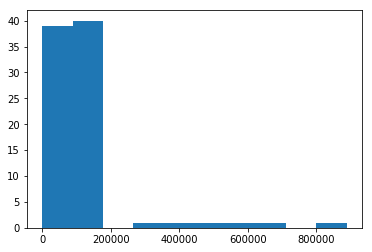

In [10]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(na_per_col)

A clearly visible pattern is that most columns miss less than 200000 values. We should remove the few columns that don't. Let's trace them first


In [11]:
delete_cols = list(na_per_col.where(na_per_col > 200000).dropna().index)
print(delete_cols)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [12]:
# Remove the outlier columns from the dataset. (We'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias.drop(delete_cols, axis=1, inplace=True)
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

We concluded that most columns don't miss more than 200000 out of the total 891221 values in the dataset. It was decided to mark those that do as outliers and delete them, those are listed below: 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP' and 'KBA05_BAUMAX'.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, we'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, we should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. 

Depending on what we observe in our comparison, this will have implications on how we approach our conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, we should continue our analysis for now using just the subset of the data with few or no missing values.**

In [13]:
# How much data is missing in each row of the dataset?
na_per_row = azdias.isna().sum(axis=1)
na_per_row.head()

0    43
1     0
2     0
3     7
4     0
dtype: int64

In [14]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
sparse_rows = na_per_row[na_per_row > 25].index
dense_rows = na_per_row[na_per_row <= 25].index
azdias_sparse = azdias.iloc[sparse_rows]
azdias_dense = azdias.iloc[dense_rows]

In [15]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
no_missing_cols = ['FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'SEMIO_ERL', 'SEMIO_KULT', 'ZABEOTYP'] # manually found
azdias_sparse_nmc = azdias_sparse[no_missing_cols]
azdias_dense_nmc = azdias_dense[no_missing_cols]
azdias_dense_nmc.head()

,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,SEMIO_ERL,SEMIO_KULT,ZABEOTYP
1,5,4,2,3,5
2,2,3,6,3,5
3,2,1,7,4,3
4,1,3,4,6,4
5,2,2,2,5,4


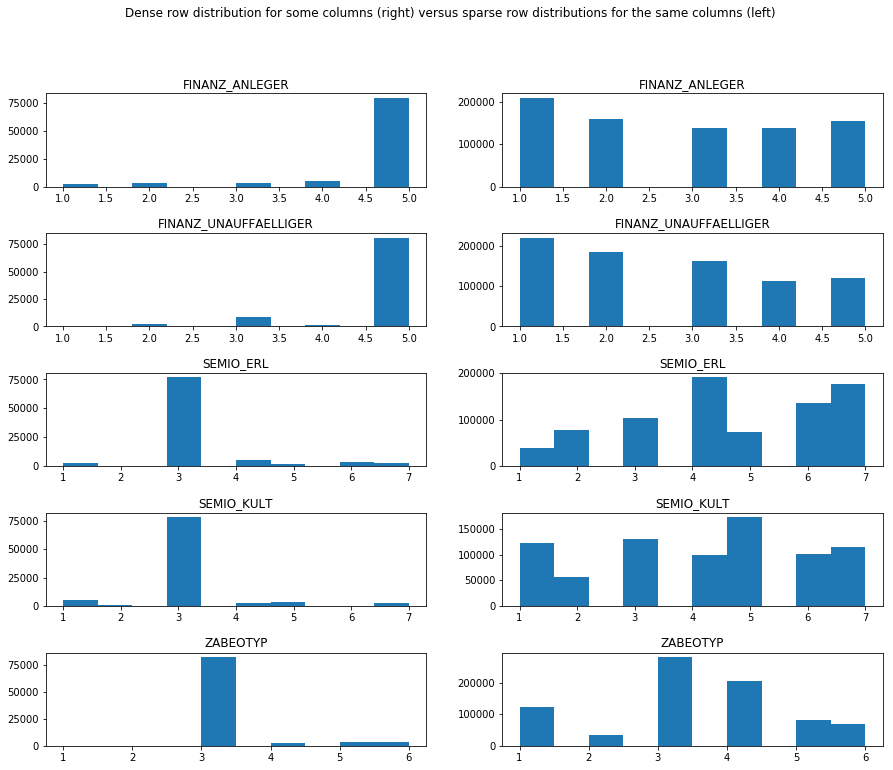

In [16]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Dense row distribution for some columns (right) versus sparse row distributions for the same columns (left)")
x = 0
y = 1
for i, col in enumerate(no_missing_cols):
    ax1 = plt.subplot(5, 2, x+1)
    ax1.hist(azdias_sparse_nmc[col])
    ax1.set_title(col)
    x += 2
    
for i, col in enumerate(no_missing_cols):
    ax1 = plt.subplot(5, 2, y+1)
    ax1.hist(azdias_dense_nmc[col])
    ax1.set_title(col)
    y += 2


#### Discussion 1.1.3: Assess Missing Data in Each Row

We observe that for the dense rows, the distributions tend to be uniform-like while for the sparse rows they tend to be dominated by a single value looking like normal or skewed distributions, this means that the sparse rows (those with lots of missing values) may have useful information that should not be discarded

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which we can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, we need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, we make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, we will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether we will keep, drop, or re-encode each. Then, in the last part, we will create a new data frame with only the selected and engineered columns.

In [17]:
# How many features are there of each data type?
feat_info.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, we would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, we will perform one of the following:
- For binary (two-level) categoricals that take numeric values, we can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, we need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), we can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis.

In [18]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_names = feat_info.attribute[feat_info.type == "categorical"] # list all categorical features
cat_names = [name for name in categorical_names if name not in delete_cols] # filter columns that were removed
azdias_cat = azdias[cat_names] # filter dataset only with categorical features
for cat_col in azdias_cat.columns: # print values in each feature
    print("Values of {}: {}".format(cat_col, azdias_cat[cat_col].unique()))

Values of ANREDE_KZ: [1 2]
Values of CJT_GESAMTTYP: [  2.   5.   3.   4.   1.   6.  nan]
Values of FINANZTYP: [4 1 6 5 2 3]
Values of GFK_URLAUBERTYP: [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
Values of GREEN_AVANTGARDE: [0 1]
Values of LP_FAMILIE_FEIN: [  2.   5.   1.  nan  10.   7.  11.   3.   8.   4.   6.   9.]
Values of LP_FAMILIE_GROB: [  2.   3.   1.  nan   5.   4.]
Values of LP_STATUS_FEIN: [  1.   2.   3.   9.   4.  10.   5.   8.   6.   7.  nan]
Values of LP_STATUS_GROB: [  1.   2.   4.   5.   3.  nan]
Values of NATIONALITAET_KZ: [ nan   1.   3.   2.]
Values of SHOPPER_TYP: [ nan   3.   2.   1.   0.]
Values of SOHO_KZ: [ nan   1.   0.]
Values of VERS_TYP: [ nan   2.   1.]
Values of ZABEOTYP: [3 5 4 1 6 2]
Values of GEBAEUDETYP: [ nan   8.   1.   3.   2.   6.   4.   5.]
Values of OST_WEST_KZ: [nan 'W' 'O']
Values of CAMEO_DEUG_2015: [nan '8' '4' '2' '6' '1' '9' '5' '7' '3']
Values of CAMEO_DEU_2015: [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' 

In [19]:
print(feat_info[feat_info.attribute.isin(cat_names)])

           attribute information_level         type missing_or_unknown
2          ANREDE_KZ            person  categorical             [-1,0]
3      CJT_GESAMTTYP            person  categorical                [0]
10         FINANZTYP            person  categorical               [-1]
12   GFK_URLAUBERTYP            person  categorical                 []
13  GREEN_AVANTGARDE            person  categorical                 []
17   LP_FAMILIE_FEIN            person  categorical                [0]
18   LP_FAMILIE_GROB            person  categorical                [0]
19    LP_STATUS_FEIN            person  categorical                [0]
20    LP_STATUS_GROB            person  categorical                [0]
21  NATIONALITAET_KZ            person  categorical             [-1,0]
38       SHOPPER_TYP            person  categorical               [-1]
39           SOHO_KZ            person  categorical               [-1]
41          VERS_TYP            person  categorical               [-1]
42    

In [20]:
# Re-encode binary categorical variable(s) to be kept in the analysis
print(azdias['OST_WEST_KZ'].head(10))
azdias['OST_WEST_KZ'] = pd.get_dummies(azdias['OST_WEST_KZ'])
azdias['OST_WEST_KZ'].head(10)

0    NaN
1      W
2      W
3      W
4      W
5      W
6      W
7      W
8      W
9      W
Name: OST_WEST_KZ, dtype: object


0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: OST_WEST_KZ, dtype: uint8

In [21]:
# drop some categorical features that seem to be similar with others
drop_cat = ['LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015']
cat_names2 = [name for name in cat_names if name not in drop_cat] 
azdias.drop(drop_cat, axis=1, inplace=True)

In [22]:
# Re-encode multi-level categorical variable(s) to be kept in the analysis.
for cat_name in cat_names2:
    azdias = pd.concat([azdias, pd.get_dummies(azdias[cat_name], prefix=cat_name)], 1) # get dummiens and place them on original df

In [23]:
azdias.drop(columns=cat_names2, inplace=True) # drop original features
pd.set_option('display.max_columns', None)
azdias.head(10)

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,ANREDE_KZ_1,ANREDE_KZ_2,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,GREEN_AVANTGARDE_0,GREEN_AVANTGARDE_1,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SOHO_KZ_0.0,SOHO_KZ_1.0,VERS_TYP_1.0,VERS_TYP_2.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,OST_WEST_KZ_0,OST_WEST_KZ_1,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9
0,2.0,3,4,3,5,5,3,NaN,15.0,4.0,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1.0,1,5,2,5,4,5,3.0,21.0,6.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
2,3.0,1,4,1,2,3,5,3.0,3.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
3,4.0,4,2,5,2,1,2,2.0,NaN,NaN,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
4,3.0,4,3,4,1,3,2,3.0,32.0,10.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
5,1.0,3,1,5,2,2,5,3.0,8.0,2.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,7.0,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.

#### Discussion 1.2.1: Re-Encode Categorical Features

In this subsection categorical variables were studied. All numeric, binary categorical variables were kept as-is. One binary categorical feature that has non-numeric values was transformed via the get dummies method. Regarding multi-level categorical features, some of them were identical describing a gross or a more detailed taxonomy of the same variable. In these cases we chose to drop the more detailed features. The remaining multi-level features, whether they were numeric or non-numeric, were transformed to multiple features via the one-hot-encoding method using the get_dummies function, and using the feature name as a prefix in order to avoid identical column names. After concatenating these multiple features at the end  of the original dataframe, the original multi-level feature columns were deleted from it

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; 
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, we should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. We will break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- For simplicity we can drop the rest of the mixed features, because their extraction is non-trivial

Let's have a quick look at mixed type variables and their values

In [24]:
mixed_names = feat_info.attribute[feat_info.type == "mixed"] # list all categorical features
mix_names = [name for name in mixed_names if name not in delete_cols] # filter columns that were removed
azdias_mix = azdias[mix_names] # filter dataset only with categorical features
for mix_col in azdias_mix.columns: # print values in each feature
    print("Values of {}: {}".format(mix_col, azdias_mix[mix_col].unique()))

Values of LP_LEBENSPHASE_FEIN: [ 15.  21.   3.  nan  32.   8.   2.   5.  10.   4.   6.  23.  12.  20.   1.
  11.  25.  13.   7.  18.  31.  19.  38.  35.  30.  22.  14.  33.  29.  24.
  28.  37.  26.  39.  27.  36.   9.  34.  40.  16.  17.]
Values of LP_LEBENSPHASE_GROB: [  4.   6.   1.  nan  10.   2.   3.   5.   7.  12.  11.   9.   8.]
Values of PRAEGENDE_JUGENDJAHRE: [ nan  14.  15.   8.   3.  10.  11.   5.   9.   6.   4.   2.   1.  12.  13.
   7.]
Values of WOHNLAGE: [ nan   4.   2.   7.   3.   5.   1.   8.   0.]
Values of CAMEO_INTL_2015: [nan '51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25'
 '23' '31' '52' '35' '45' '44' '32']
Values of PLZ8_BAUMAX: [ nan   1.   2.   4.   5.   3.]


# "PRAEGENDE_JUGENDJAHRE" explained values
* 1: 40s - war years (Mainstream, E+W)
* 2: 40s - reconstruction years (Avantgarde, E+W)
* 3: 50s - economic miracle (Mainstream, E+W)
* 4: 50s - milk bar / Individualisation (Avantgarde, E+W)
* 5: 60s - economic miracle (Mainstream, E+W)
* 6: 60s - generation 68 / student protestors (Avantgarde, W)
* 7: 60s - opponents to the building of the Wall (Avantgarde, E)
* 8: 70s - family orientation (Mainstream, E+W)
* 9: 70s - peace movement (Avantgarde, E+W)
* 10: 80s - Generation Golf (Mainstream, W)
* 11: 80s - ecological awareness (Avantgarde, W)
* 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
* 13: 80s - Swords into ploughshares (Avantgarde, E)
* 14: 90s - digital media kids (Mainstream, E+W)
* 15: 90s - ecological awareness (Avantgarde, E+W)


In [25]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# replace encoded values with their text meanings
temp_df1 = azdias["PRAEGENDE_JUGENDJAHRE"].replace(
        [1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12., 13., 14., 15.], 
          ['40s - war years (Mainstream, E+W)', '40s - reconstruction years (Avantgarde, E+W)', '50s - economic miracle (Mainstream, E+W)', 
           '50s - milk bar / Individualisation (Avantgarde, E+W)', '60s - economic miracle (Mainstream, E+W)', '60s - generation 68 / student protestors (Avantgarde, W)', 
           '60s - opponents to the building of the Wall (Avantgarde, E)', '70s - family orientation (Mainstream, E+W)', '70s - peace movement (Avantgarde, E+W)',
           '80s - Generation Golf (Mainstream, W)', '80s - ecological awareness (Avantgarde, W)', '80s - FDJ / communist party youth organisation (Mainstream, E)', 
           '80s - Swords into ploughshares (Avantgarde, E)', '90s - digital media kids (Mainstream, E+W)', '90s - ecological awareness (Avantgarde, E+W)'
          ])

decade = temp_df1.str.split('-').str[0].str.replace("s", "").astype("float") # extract decade with string manipualtion
print(decade.head())
movement = temp_df1.str.split('-').str[1].str.split('(').str[1].str.split(',').str[0] # extract movement
print(movement.head())

# let's add them as new features
azdias["decade"] = decade
azdias["movement"] = movement
pd.set_option('display.max_columns', None)
azdias.head

0     NaN
1    90.0
2    90.0
3    70.0
4    70.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64
0           NaN
1    Mainstream
2    Avantgarde
3    Mainstream
4    Mainstream
Name: PRAEGENDE_JUGENDJAHRE, dtype: object


<bound method NDFrame.head of         ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                        2.0                  3              4   
1                        1.0                  1              5   
2                        3.0                  1              4   
3                        4.0                  4              2   
4                        3.0                  4              3   
5                        1.0                  3              1   
6                        2.0                  1              5   
7                        1.0                  3              3   
8                        3.0                  4              4   
9                        3.0                  2              4   
10                       3.0                  2              2   
11                       2.0                  3              4   
12                       3.0                  5              3   
13                       1.0                  

# "CAMEO_INTL_2015" explained values
* 11: Wealthy Households - Pre-Family Couples & Singles
* 12: Wealthy Households - Young Couples With Children
* 13: Wealthy Households - Families With School Age Children
* 14: Wealthy Households - Older Families & Mature Couples
* 15: Wealthy Households - Elders In Retirement
* 21: Prosperous Households - Pre-Family Couples & Singles
* 22: Prosperous Households - Young Couples With Children
* 23: Prosperous Households - Families With School Age Children
* 24: Prosperous Households - Older Families & Mature Couples
* 25: Prosperous Households - Elders In Retirement
* 31: Comfortable Households - Pre-Family Couples & Singles
* 32: Comfortable Households - Young Couples With Children
* 33: Comfortable Households - Families With School Age Children
* 34: Comfortable Households - Older Families & Mature Couples
* 35: Comfortable Households - Elders In Retirement
* 41: Less Affluent Households - Pre-Family Couples & Singles
* 42: Less Affluent Households - Young Couples With Children
* 43: Less Affluent Households - Families With School Age Children
* 44: Less Affluent Households - Older Families & Mature Couples
* 45: Less Affluent Households - Elders In Retirement
* 51: Poorer Households - Pre-Family Couples & Singles
* 52: Poorer Households - Young Couples With Children
* 53: Poorer Households - Families With School Age Children
* 54: Poorer Households - Older Families & Mature Couples
* 55: Poorer Households - Elders In Retirement


In [26]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

wealth = azdias["CAMEO_INTL_2015"].astype(float)//10 # keep decade
life_stage = azdias["CAMEO_INTL_2015"].astype(float)%10 # keep last digit
print(wealth.head())
print(life_stage.head())

# add them to the original dataframe
azdias["wealth"] = wealth
azdias["life_stage"] = life_stage
pd.set_option('display.max_columns', None)
azdias.head

0    NaN
1    5.0
2    2.0
3    1.0
4    4.0
Name: CAMEO_INTL_2015, dtype: float64
0    NaN
1    1.0
2    4.0
3    2.0
4    3.0
Name: CAMEO_INTL_2015, dtype: float64


<bound method NDFrame.head of         ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                        2.0                  3              4   
1                        1.0                  1              5   
2                        3.0                  1              4   
3                        4.0                  4              2   
4                        3.0                  4              3   
5                        1.0                  3              1   
6                        2.0                  1              5   
7                        1.0                  3              3   
8                        3.0                  4              4   
9                        3.0                  2              4   
10                       3.0                  2              2   
11                       2.0                  3              4   
12                       3.0                  5              3   
13                       1.0                  

For simplicity reasons, we will drop the rest of the mixed features from the analysis, this will also drop the the two original features for which we extracted lower level features above

In [27]:
azdias.drop(columns=azdias_mix.columns, inplace=True)
pd.set_option('display.max_columns', None)
azdias.head

<bound method NDFrame.head of         ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                        2.0                  3              4   
1                        1.0                  1              5   
2                        3.0                  1              4   
3                        4.0                  4              2   
4                        3.0                  4              3   
5                        1.0                  3              1   
6                        2.0                  1              5   
7                        1.0                  3              3   
8                        3.0                  4              4   
9                        3.0                  2              4   
10                       3.0                  2              2   
11                       2.0                  3              4   
12                       3.0                  5              3   
13                       1.0                  

#### Discussion 1.2.2: Engineer Mixed-Type Features

Regarding the mixed type features, we kept in the analysis "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015". We split the first one into two featues, namely "decade" and "movement" by using string splitting techniques. For the second one, we used the "//" and "%" operators to also split into two ordinal features, "wealth" and "life_stage"

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, we need to make sure that our data frame now only has the columns that we want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

In [28]:
pd.set_option('display.max_columns', None)
azdias.head

<bound method NDFrame.head of         ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                        2.0                  3              4   
1                        1.0                  1              5   
2                        3.0                  1              4   
3                        4.0                  4              2   
4                        3.0                  4              3   
5                        1.0                  3              1   
6                        2.0                  1              5   
7                        1.0                  3              3   
8                        3.0                  4              4   
9                        3.0                  2              4   
10                       3.0                  2              2   
11                       2.0                  3              4   
12                       3.0                  5              3   
13                       1.0                  

Even though we extractded the movement feature from a mixed fetaure, it is still a binary categorical feature that should be converted to contain numeric dummy values. Let's do this change

In [29]:
azdias['movement'] = pd.get_dummies(azdias['movement'])
pd.set_option('display.max_columns', None)
azdias.head

<bound method NDFrame.head of         ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                        2.0                  3              4   
1                        1.0                  1              5   
2                        3.0                  1              4   
3                        4.0                  4              2   
4                        3.0                  4              3   
5                        1.0                  3              1   
6                        2.0                  1              5   
7                        1.0                  3              3   
8                        3.0                  4              4   
9                        3.0                  2              4   
10                       3.0                  2              2   
11                       2.0                  3              4   
12                       3.0                  5              3   
13                       1.0                  

### Step 1.3: Create a Cleaning Function

Even though we've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that we'll need to perform the same cleaning steps on the customer demographics data. In this substep, let's complete the function below to execute the main feature selection, encoding, and re-engineering steps we performed above.

In [30]:
def clean_data(df, na_col_lim):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    for row in feat_info.iterrows():
        attr = row[1].attribute
        nan_alts = feat_info.missing_or_unknown.iloc[row[0]]
        nan_alts2 = nan_alts.split(",")
        nan_alts3 = [alt.replace("[", "").replace("]", "") for alt in nan_alts2]
        if '' in nan_alts3:
            continue;
    
        for alt in nan_alts3:
            if not (alt == 'X' or alt == 'XX'):
                alt = int(alt)
            df[attr].replace(alt, np.nan, inplace=True)

    
    # remove selected columns and rows, ...
    na_per_col = df.isna().sum()
    delete_cols = list(na_per_col.where(na_per_col > na_col_lim).dropna().index)
    # This will delete some columns, to safeguard all the columns access steps below this point
    # we will use if statements
    df.drop(delete_cols, axis=1, inplace=True)
    
    # select, re-encode, and engineer column values.
    categorical_names = feat_info.attribute[feat_info.type == "categorical"] # list all categorical features
    cat_names = [name for name in categorical_names if name not in delete_cols] # filter columns that were removed
    if 'OST_WEST_KZ' in df.columns:
        df['OST_WEST_KZ'] = pd.get_dummies(df['OST_WEST_KZ'])
    drop_cat = ['LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015']
    cat_names2 = [name for name in cat_names if name not in drop_cat]
    for feat in drop_cat:
        if feat in df.columns:
            df.drop([feat], axis=1, inplace=True)
    for cat_name in cat_names2:
        if cat_name in df.columns:
            df = pd.concat([df, pd.get_dummies(df[cat_name], prefix=cat_name)], 1)
    
    for cat_name in cat_names2:
        if cat_name in df.columns:
            df.drop(columns=cat_name, inplace=True)
    
    #mixed
    mixed_names = feat_info.attribute[feat_info.type == "mixed"] # list all categorical features
    mix_names = [name for name in mixed_names if name not in delete_cols] # filter columns that were removed
    df_mix = df[mix_names] # filter dataset only with categorical features
    
    if "PRAEGENDE_JUGENDJAHRE" in df.columns:
        temp_df1 = df["PRAEGENDE_JUGENDJAHRE"].replace(
            [1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12., 13., 14., 15.], 
              ['40s - war years (Mainstream, E+W)', '40s - reconstruction years (Avantgarde, E+W)', '50s - economic miracle (Mainstream, E+W)', 
               '50s - milk bar / Individualisation (Avantgarde, E+W)', '60s - economic miracle (Mainstream, E+W)', '60s - generation 68 / student protestors (Avantgarde, W)', 
               '60s - opponents to the building of the Wall (Avantgarde, E)', '70s - family orientation (Mainstream, E+W)', '70s - peace movement (Avantgarde, E+W)',
               '80s - Generation Golf (Mainstream, W)', '80s - ecological awareness (Avantgarde, W)', '80s - FDJ / communist party youth organisation (Mainstream, E)', 
               '80s - Swords into ploughshares (Avantgarde, E)', '90s - digital media kids (Mainstream, E+W)', '90s - ecological awareness (Avantgarde, E+W)'
              ])

        decade = temp_df1.str.split('-').str[0].str.replace("s", "").astype("float")
        movement = temp_df1.str.split('-').str[1].str.split('(').str[1].str.split(',').str[0]


        df["decade"] = decade
        df["movement"] = movement
        df['movement'] = pd.get_dummies(df['movement'])
    
    if "CAMEO_INTL_2015" in df.columns:
        wealth = df["CAMEO_INTL_2015"].astype(float)//10 # keep decade
        life_stage = df["CAMEO_INTL_2015"].astype(float)%10 # keep last digit

        df["wealth"] = wealth
        df["life_stage"] = life_stage
    
    df.drop(columns=df_mix.columns, inplace=True)

    
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. In this substep, we'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to our data, we must make sure that we've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. We might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. 
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, we can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. 

In [31]:
# Since we also have some categorical features, let's impute with most frequent (mode) value along columns
import sklearn
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="most_frequent")
azdias_imputed = imputer.fit_transform(azdias)

In [32]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_imputed), columns=azdias.columns)
print(azdias_scaled.head())

   ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  \
0             -0.751680          -0.056416       0.804890         -0.303378   
1             -1.743339          -1.570358       1.487601         -1.059731   
2              0.239980          -1.570358       0.804890         -1.816084   
3              1.231640           0.700556      -0.560532          1.209329   
4              0.239980           0.700556       0.122179          0.452976   

   FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  HEALTH_TYP  \
0        1.285741               1.429871         -0.055511    0.938197   
1        1.285741               0.757254          1.422415    0.938197   
2       -0.675554               0.084637          1.422415    0.938197   
3       -0.675554              -1.260597         -0.794475   -0.385397   
4       -1.329319               0.084637         -0.794475    0.938197   

   RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  \
0  

### Discussion 2.1: Apply Feature Scaling

Beacuse scalers in sklearn can't handle missing values we first impute them and then apply the scaler. Also, because we have both categorical and numerical data, we choose to impute with the most frequent value (mode) of each column. Mode is more suitable for categorical values, but mean is better for numerical data, so as an improvement note, a more sophisticatd approach where a different imputer is applied to each column, might have been more suitable. Also in later versions of sklearn, not available in the Udacity workspace, more sophisticated imputation methods like [KNN imputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) can be easily used.

### Step 2.2: Perform Dimensionality Reduction

On our scaled data, we are now ready to apply dimensionality reduction techniques.

- We'll use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, we should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- We'll check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Based on what we find, we will select a value for the number of transformed features we'll retain for the clustering part of the project.

In [33]:
n_comp = azdias_scaled.shape[1]
print(n_comp)

132


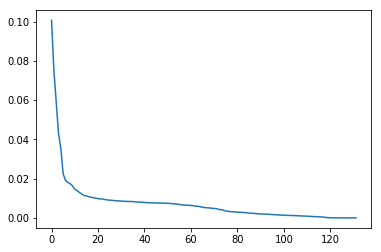

In [34]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(azdias_scaled)
variance_array = pca.explained_variance_ratio_
cum_var = np.cumsum(variance_array) # cumulative variance
plt.plot(variance_array)

In [35]:
print("Explained variance:")
print(pca.explained_variance_ratio_.sum())

Explained variance:
1.0


Up to component: 0, cumulative variance expained: 0.1006641023015212
Up to component: 10, cumulative variance expained: 0.4215912070454379
Up to component: 20, cumulative variance expained: 0.5347671484569632
Up to component: 30, cumulative variance expained: 0.6253163037047745
Up to component: 40, cumulative variance expained: 0.7074055662630658
Up to component: 50, cumulative variance expained: 0.7835381792099921
Up to component: 60, cumulative variance expained: 0.8516972480306307
Up to component: 70, cumulative variance expained: 0.9061482203267867
Up to component: 80, cumulative variance expained: 0.9424889050094496
Up to component: 90, cumulative variance expained: 0.966922069691888
Up to component: 100, cumulative variance expained: 0.9839042965728247
Up to component: 110, cumulative variance expained: 0.9951371088842772
Up to component: 120, cumulative variance expained: 0.9999348627147563
Up to component: 130, cumulative variance expained: 1.0


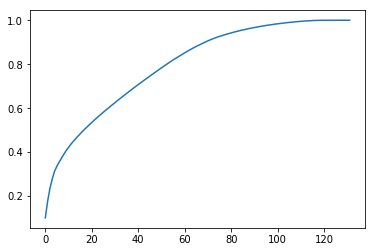

In [36]:
# Investigate the variance accounted for every next 10 principal components.
for i in (np.arange(0, n_comp, 10)):
    print("Up to component: {}, cumulative variance expained: {}".format(i, cum_var[i]))
plt.plot(cum_var)

In [37]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_70 = PCA(n_components=70)
pca_70.fit(azdias_scaled)
azdias_pca_70 = pca_70.transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

After performing principal component analysis we concluded that the first 20 out of 132 componentes explain approximately half the variance of the data, while 70 components are enough to explain approximately 90% of the variance. We will keep 70 componentes for the next part of the analysis.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, we should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. 
- We should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, we should write a function that we can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [38]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def map_comp_weights(df, pca, component):
    comp_weights = pd.DataFrame(pca.components_, columns=list(df.columns)).iloc[component]
    comp_weights.sort_values(ascending=False, inplace=True)
    return comp_weights
    
weights_comp1 = map_comp_weights(azdias_scaled, pca_70, 0)
print(weights_comp1.head())
weights_comp1.tail()

wealth                0.188326
PLZ8_ANTG3            0.181524
LP_STATUS_GROB_1.0    0.173218
FINANZ_SPARER         0.166405
EWDICHTE              0.159909
Name: 0, dtype: float64


KBA05_GBZ           -0.176442
PLZ8_ANTG1          -0.180670
KBA05_ANTG1         -0.189728
MOBI_REGIO          -0.196330
FINANZ_MINIMALIST   -0.208487
Name: 0, dtype: float64

In [39]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights_comp2 = map_comp_weights(azdias_scaled, pca_70, 1)
print(weights_comp2.head())
weights_comp2.tail()

ALTERSKATEGORIE_GROB    0.212613
FINANZ_VORSORGER        0.201307
SEMIO_ERL               0.182924
ZABEOTYP_3              0.159975
RETOURTYP_BK_S          0.151152
Name: 1, dtype: float64


FINANZ_ANLEGER          -0.193375
FINANZ_SPARER           -0.204309
SEMIO_REL               -0.205956
FINANZ_UNAUFFAELLIGER   -0.210875
decade                  -0.217509
Name: 1, dtype: float64

In [40]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights_comp3 = map_comp_weights(azdias_scaled, pca_70, 2)
print(weights_comp3.head())
weights_comp3.tail()

SEMIO_VERT     0.293307
ANREDE_KZ_1    0.260498
SEMIO_SOZ      0.260430
SEMIO_KULT     0.258640
SOHO_KZ_0.0    0.184238
Name: 2, dtype: float64


SEMIO_ERL     -0.144126
SEMIO_DOM     -0.251378
ANREDE_KZ_2   -0.260498
SEMIO_KRIT    -0.272005
SEMIO_KAEM    -0.280451
Name: 2, dtype: float64

### Discussion 2.3: Interpret Principal Components

For the first component we notice that it is positively correlated with features related to the financial status and negatively correlated with features related to the housing situation. The second component seems to be negatively correlated with financial features and positively correlated with some more general traits (age, personality etc.). Finally the third component seems to also be positively correlated with some traits like personality, gender etc. while it is also negatively correlated with different personality and gender information.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

We've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, we will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- We'll use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, we'll compute the average difference from each point to its assigned cluster's center.
- We'll perform the above two steps for a number of different cluster counts. We can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. We'll use this fact to select a final number of clusters in which to group the data.
- Once we've selected a final number of clusters to use, we'll re-fit a KMeans instance to perform the clustering operation. 

In [41]:
from sklearn.cluster import KMeans
kmeans_3 = KMeans(3)
model_3 = kmeans_3.fit(azdias_pca_70)
score_3 = np.abs(model_3.score(azdias_pca_70))
print("score for 3 clusters: {}".format(score_3))

kmeans_7 = KMeans(7)
model_7 = kmeans_7.fit(azdias_pca_70)
score_7 = np.abs(model_7.score(azdias_pca_70))
print("score for 7clusters: {}".format(score_7))

score for 3 clusters: 92101570.41748463
score for 7clusters: 80754807.40944879


In [42]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

scores = []
ks = []
for k in range(20):
    kmeans = KMeans(int(k+1))
    model = kmeans.fit(azdias_pca_70)
    score = np.abs(model.score(azdias_pca_70))
    ks.append(k+1)
    scores.append(abs(score))
    


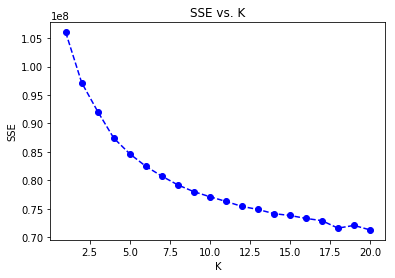

In [43]:
plt.plot(ks, scores, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [44]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(16)
model = kmeans.fit(azdias_pca_70)
kmeans_pred_azdias = kmeans.predict(azdias_pca_70)

### Discussion 3.1: Apply Clustering to General Population

We notice that the sum of squared errors (SSE) keeps decreasing with the number of clusters. After 16 clusters to plot seems to decay slowly to a plateau, so we will stick with a 16 cluster approach

### Step 3.2: Apply All Steps to the Customer Data

Now that we have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. We should not re-fit all of the models to the customer data. Instead, we're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, we will interpret how the general population fits apply to the customer data.

In [45]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter=";")
print(customers.shape)
customers.head()

(191652, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [46]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean = clean_data(customers, 60000)

In [47]:
print(customers_clean.shape)
customers_clean.head()

(191652, 129)


,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,MOBI_REGIO,ONLINE_AFFINITAET,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,ANREDE_KZ_1,ANREDE_KZ_2,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,GREEN_AVANTGARDE_0,GREEN_AVANTGARDE_1,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SOHO_KZ_0.0,SOHO_KZ_1.0,VERS_TYP_1.0,VERS_TYP_2.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,OST_WEST_KZ_0,OST_WEST_KZ_1,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,decade,movement,wealth,life_stage
0,4.0,5,1,5,1,2,2,1.0,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,2.0,0.0,1.0,6.0,9.0,1.0,0.0,5.0,1992.0,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,4.0,3.0,1201.0,3.0,3.0,1.0,0.0,5.0,5.0,1.0,2.0,1.0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,50.0,1,1.0,3.0
1,4.0,5,1,5,1,3,2,1.0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3.0,0.0,NaN,NaN,9.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,0,NaN,NaN
2,4.0,5,1,5,1,4,4,2.0,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,1992.0,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,1.0,433.0,2.0,3.0,3.0,1.0,3.0,2.0,3.0,5.0,3.0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,50.0,1,3.0,4.0
3,4.0,5,1,5,2,1,2,2.0,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0.0,0.0,4.0,NaN,9.0,NaN,NaN,2.0,1992.0,3.0,0.0,0.0,0.0,4.0,7.0,1.0,7.0,4.0,4.0,2.0,755.0,3.0,2.0,1.0,0.0,3.0,4.0,1.0,3.0,1.0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,40.0,0,2.0,4.0
4,3.0,3,1,4,4,5,2,3.0,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,4.0,0.0,6.0,2.0,9.0,7.0,0.0,1.0,1992.0,0.0,3.0,2.0,0.0,3.0,3.0,4.0,4.0,3.0,3.0,5.0,513.0,2.0,4.0,2.0,1.0,3.0,3.0,3.0,5.0,1.0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,70.0,0,4.0,1.0


In [48]:
customers_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 129 entries, ALTERSKATEGORIE_GROB to life_stage
dtypes: float64(36), int64(20), uint8(73)
memory usage: 95.2 MB


In [49]:
customers_clean.isna().sum()

ALTERSKATEGORIE_GROB       240
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
HEALTH_TYP               48990
RETOURTYP_BK_S            3213
SEMIO_SOZ                    0
SEMIO_FAM                    0
SEMIO_REL                    0
SEMIO_MAT                    0
SEMIO_VERT                   0
SEMIO_LUST                   0
SEMIO_ERL                    0
SEMIO_KULT                   0
SEMIO_RAT                    0
SEMIO_KRIT                   0
SEMIO_DOM                    0
SEMIO_KAEM                   0
SEMIO_PFLICHT                0
SEMIO_TRADV                  0
ANZ_PERSONEN             46596
ANZ_TITEL                46596
HH_EINKOMMEN_SCORE        2968
W_KEIT_KIND_HH           56937
WOHNDAUER_2008           46596
ANZ_HAUSHALTE_AKTIV      52377
ANZ_HH_TITEL             52110
                         ...  
SOHO_KZ_1.0                  0
VERS_TYP

### Step 3.3: Compare Customer Data to Demographics Data

At this point, we have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, we will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? We'll select at least one such cluster and infer what kind of people might be represented by that cluster. We'll use the principal component interpretations from step 2.3 or look at additional components to help us make this inference. Alternatively, we can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- We'll perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

The clean customer dataset, has 129 columns as opposed to the 132 columns of the clean citizen dataset. This will create issues when transforimng on the pre-fitted scaler and PCA models, to counter-act this, we will insert 3 dummy columns on the customer dataset

In [50]:
customers_clean['dummy1'] = 0
customers_clean['dummy2'] = 0
customers_clean['dummy3'] = 0
customers_clean.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,MOBI_REGIO,ONLINE_AFFINITAET,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,ANREDE_KZ_1,ANREDE_KZ_2,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,GREEN_AVANTGARDE_0,GREEN_AVANTGARDE_1,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SOHO_KZ_0.0,SOHO_KZ_1.0,VERS_TYP_1.0,VERS_TYP_2.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,OST_WEST_KZ_0,OST_WEST_KZ_1,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,decade,movement,wealth,life_stage,dummy1,dummy2,dummy3
0,4.0,5,1,5,1,2,2,1.0,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,2.0,0.0,1.0,6.0,9.0,1.0,0.0,5.0,1992.0,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,4.0,3.0,1201.0,3.0,3.0,1.0,0.0,5.0,5.0,1.0,2.0,1.0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,50.0,1,1.0,3.0,0,0,0
1,4.0,5,1,5,1,3,2,1.0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3.0,0.0,NaN,NaN,9.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,0,NaN,NaN,0,0,0
2,4.0,5,1,5,1,4,4,2.0,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,1992.0,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,1.0,433.0,2.0,3.0,3.0,1.0,3.0,2.0,3.0,5.0,3.0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,50.0,1,3.0,4.0,0,0,0
3,4.0,5,1,5,2,1,2,2.0,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0.0,0.0,4.0,NaN,9.0,NaN,NaN,2.0,1992.0,3.0,0.0,0.0,0.0,4.0,7.0,1.0,7.0,4.0,4.0,2.0,755.0,3.0,2.0,1.0,0.0,3.0,4.0,1.0,3.0,1.0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,40.0,0,2.0,4.0,0,0,0
4,3.0,3,1,4,4,5,2,3.0,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,4.0,0.0,6.0,2.0,9.0,7.0,0.0,1.0,1992.0,0.0,3.0,2.0,0.0,3.0,3.0,4.0,4.0,3.0,3.0,5.0,513.0,2.0,4.0,2.0,1.0,3.0,3.0,3.0,5.0,1.0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,70.0,0,4.0,1.0,0,0,0


In [64]:
customers_imputed = imputer.fit_transform(customers_clean)
customers_scaled = pd.DataFrame(scaler.transform(customers_imputed), columns=customers_clean.columns)

In [65]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
customers_pca_70 = pca_70.transform(customers_scaled)
kmeans_pred_customers = kmeans.predict(customers_pca_70)

Text(0.5,1,'Customer clusters')

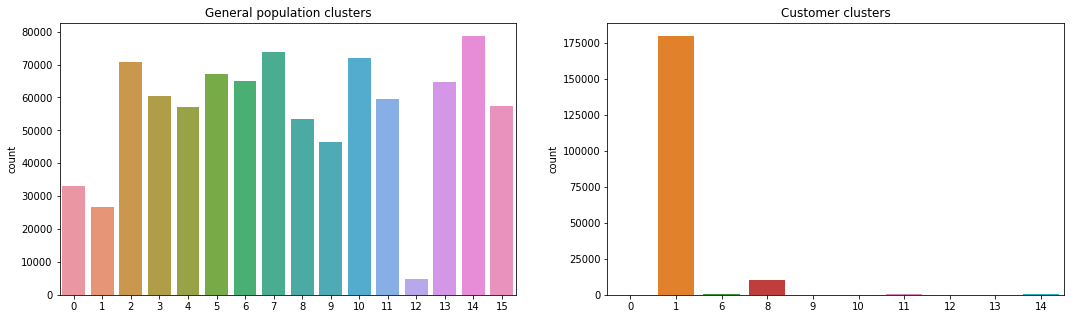

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
sns.countplot(kmeans_pred_azdias, ax=ax1);
ax1.set_title("General population clusters")
# plt.ylabel("count")
sns.countplot(kmeans_pred_customers, ax=ax2);
ax2.set_title("Customer clusters")
# plt.ylabel("count")

In [67]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
customer_over_cluster = 1 # overepresetned in customer and underepresented in population
customer_under_cluster = 14 # overepresetned in population but underepresented in customers

In [68]:
centroid_over = scaler.inverse_transform(pca_70.inverse_transform(kmeans.cluster_centers_[customer_over_cluster]))

Let's print the overeprestned and underepresented features in weight descending order to help us recognize them

In [69]:
overep = pd.Series(data=centroid_over, index=customers_clean.columns)
print(overep.sort_values(ascending=False))

MIN_GEBAEUDEJAHR         2.003511e+03
PLZ8_ANTG2               8.880765e+02
life_stage               8.304625e+01
WOHNDAUER_2008           7.065747e+00
INNENSTADT               5.443684e+00
PLZ8_ANTG1               5.420075e+00
SEMIO_VERT               5.106578e+00
SEMIO_KRIT               5.046106e+00
BALLRAUM                 4.986150e+00
SEMIO_MAT                4.972403e+00
SEMIO_RAT                4.418167e+00
SEMIO_ERL                4.355117e+00
SEMIO_TRADV              4.268006e+00
SEMIO_FAM                4.251654e+00
SEMIO_KAEM               4.231620e+00
SEMIO_PFLICHT            4.151667e+00
SEMIO_DOM                4.127107e+00
KBA13_ANZAHL_PKW         4.083502e+00
GEBAEUDETYP_RASTER       4.080403e+00
FINANZ_MINIMALIST        4.071279e+00
KONSUMNAEHE              4.054189e+00
FINANZ_UNAUFFAELLIGER    3.935141e+00
SEMIO_REL                3.929158e+00
SEMIO_KULT               3.910402e+00
ANREDE_KZ_1              3.769046e+00
ORTSGR_KLS9              3.562063e+00
FINANZ_ANLEG

In [70]:
centroid_under = scaler.inverse_transform(pca_70.inverse_transform(kmeans.cluster_centers_[customer_under_cluster]))

In [71]:
underep = pd.Series(data=centroid_under, index=customers_clean.columns)
print(underep.sort_values(ascending=False))

MIN_GEBAEUDEJAHR         1.992660e+03
PLZ8_ANTG2               5.650308e+02
life_stage               8.776966e+01
ANZ_HAUSHALTE_AKTIV      1.321503e+01
WOHNDAUER_2008           7.262971e+00
ANREDE_KZ_1              6.787651e+00
SEMIO_PFLICHT            6.229453e+00
SEMIO_RAT                6.180333e+00
SEMIO_DOM                6.145042e+00
SEMIO_KAEM               6.130309e+00
SEMIO_TRADV              5.695734e+00
HH_EINKOMMEN_SCORE       5.588141e+00
SEMIO_KRIT               5.494472e+00
SEMIO_REL                5.468727e+00
EWDICHTE                 5.099481e+00
PLZ8_ANTG1               5.073466e+00
SEMIO_MAT                4.882852e+00
FINANZ_SPARER            4.446249e+00
dummy2                   4.403008e+00
FINANZ_ANLEGER           4.281759e+00
W_KEIT_KIND_HH           4.239049e+00
SEMIO_ERL                4.225859e+00
FINANZ_HAUSBAUER         4.159706e+00
SEMIO_KULT               4.156111e+00
SEMIO_FAM                3.994672e+00
FINANZ_UNAUFFAELLIGER    3.928628e+00
ARBEIT      

### Discussion 3.3: Compare Customer Data to Demographics Data

We have recognised the most overepresented and underepresented clusters in the customer dataset. We have also traced back to the correlation of the original features with these clusters and printed them in descending order which can help us recognise which parts of the population are overepresented and which are underepresented. The three most importan features for the underepresented and overepresented cluster, happen to be the same, namely MIN_GEBAEUDEJAHR, PLZ8_ANTG2 and life_stage.  Let's comment on the three most negatively correlated features for the overepresented and underepresented cluster:

Overepresented:

* GEBAEUDETYP_4.0 : type of building =  mixed building without actually known household or company
* wealth : 1-5 wealthy to poor housleholds
* FINANZTYP_6 : financial type = inconspicuous

Underepresented:
* NATIONALITAET_KZ_2.0 : german sounding
* NATIONALITAET_KZ_1.0 : Foreign sounding
* CJT_GESAMTTYP_1.0 : Advertising- and Consumptionminimalist

**The overeprsented cluster seems to be negatively correlated with features depicting a person's orhousehold's financial status. Financially inconspicuous people, poor households and mixed buildings without actually known household or company are negatively correlated with the overepresented cluster in the customer dataset and customer groups that  the company should potentially target in the future.** On the other hand, the underepresented cluster is negatively correlated with features depicting a person's nationality and consumption habbits but not very useful conclusions can come out of this. Both clusters are positively correlated with features related with building and life stage attributes